## Download dataset

In [ ]:
# # v1 dataset
# !curl -L -o dataset-sign.zip "https://drive.usercontent.google.com/download?id=101vuY4B474fMy9C_derEIxAVxd2ARc9U&authuser=0&confirm=t&uuid=6a6ac8c3-7881-4834-a58e-0cc7ae1ee7f4&at=AENtkXaM-csHzbMhZl547eqBHlvq%3A1732197046359"

# v4 dataset (new data)
# !curl -L -o dataset-sign-new-v4.zip "https://drive.usercontent.google.com/download?id=1WW-z1lh1gV5WKr93ds4dGGTVPSopLR66&export=download&authuser=0&confirm=t&uuid=43aca4da-118e-4d0a-910e-6f26e0fe777e&at=APvzH3phEqJs2jGEEuDAJq33eVKL:1733654299652"

# v3 dataset (cropped new data)
!curl -L -o dataset-sign-cropped-v6.zip "https://drive.usercontent.google.com/download?id=1wCXkT6hStFIps7V0PL9iQebnaM2e2fmb&export=download&authuser=0&confirm=t&uuid=7eab381b-3680-4930-b151-bbca4ed4118d&at=APvzH3q69JJ2gsJFP7qJisFQqnrl:1733735009489"



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1753M  100 1753M    0     0  47.3M      0  0:00:37  0:00:37 --:--:-- 64.2M


In [ ]:
%%capture
!unzip dataset-sign-cropped-v6.zip

## Install libraries

In [ ]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 53.7 MB/s eta 0:00:00


## Dataset preparations

In [ ]:
import os
import cv2
import numpy as np
import mediapipe as mp

In [ ]:
import tensorflow as tf

IMG_WIDTH = 128
IMG_HEIGHT = 128
image_size = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 128
BUFFER_SIZE = tf.data.AUTOTUNE

# Define the directory where your data is located.  Replace with your actual path.
train_data_dir = "train_cropped"
validation_data_dir = "val_cropped"

# Data augmentation function
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    return image, label

with tf.device('/GPU:0'):

    # Create data loaders for train and validation sets
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        train_data_dir,
        labels='inferred',
        label_mode='categorical', # or 'int', 'binary' depending on your task
        image_size=image_size,
        interpolation="nearest",
        batch_size=BATCH_SIZE,
        shuffle=True
    )

    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        validation_data_dir,
        labels='inferred',
        label_mode='categorical', # or 'int', 'binary' depending on your task
        image_size=image_size,
        interpolation="nearest",
        batch_size=BATCH_SIZE,
        shuffle=True
    )

    # Calculate the number of batches to take for 50% of the dataset
    train_dataset_size = tf.data.experimental.cardinality(train_dataset).numpy()
    validation_dataset_size = tf.data.experimental.cardinality(validation_dataset).numpy()

    # Augment training data
    train_dataset = train_dataset.map(augment, num_parallel_calls=BUFFER_SIZE)

    # Configure dataset for performance
    train_dataset = train_dataset.prefetch(buffer_size=BUFFER_SIZE)
    validation_dataset = validation_dataset.prefetch(buffer_size=BUFFER_SIZE)
    # train_dataset = train_dataset.cache().prefetch(buffer_size=BUFFER_SIZE)
    # validation_dataset = validation_dataset.cache().prefetch(buffer_size=BUFFER_SIZE)

# Example usage (print the shapes of the first batch)
for image_batch, labels_batch in train_dataset:
    print("Image batch shape:", image_batch.shape)
    print("Labels batch shape:", labels_batch.shape)
    break # exit after first batch

Found 184444 files belonging to 29 classes.
Found 20480 files belonging to 29 classes.


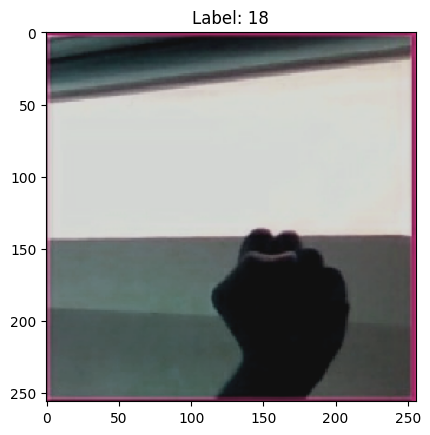

In [ ]:
import matplotlib.pyplot as plt

# Get a sample image and its label from the training dataset
for image_batch, labels_batch in train_dataset:
    sample_image = image_batch[0]
    sample_label = labels_batch[0]
    break

# Convert the tensor image to a NumPy array
sample_image = sample_image.numpy().astype(np.uint8)

# Display the image
plt.imshow(sample_image)
plt.title(f"Label: {np.argmax(sample_label)}")
plt.show()

## Training

#### Using .fit()

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import gc
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import Callback

class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        k.clear_session()

with tf.device('/GPU:0'):
    # Load pre-trained ResNet50 model (excluding the top classification layer)
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(29, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], run_eagerly=False)

    # Train the model with Weights & Biases callback
    model.fit(
        train_dataset,
        epochs=5,  # Adjust the number of epochs
        validation_data=validation_dataset,
        callbacks=ClearMemory()
    )

    # # Save the model (optional)
    # model.save("sign_language_model.keras")

Epoch 1/5
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 347s 231ms/step - accuracy: 0.8383 - loss: 0.5974 - val_accuracy: 0.9579 - val_loss: 0.1319
Epoch 2/5
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 315s 217ms/step - accuracy: 0.9611 - loss: 0.1199 - val_accuracy: 0.9706 - val_loss: 0.0869
Epoch 3/5
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 332s 224ms/step - accuracy: 0.9709 - loss: 0.0911 - val_accuracy: 0.9778 - val_loss: 0.0676
Epoch 4/5
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 371s 215ms/step - accuracy: 0.9748 - loss: 0.0762 - val_accuracy: 0.9818 - val_loss: 0.0585
Epoch 5/5
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 323s 216ms/step - accuracy: 0.9792 - loss: 0.0657 - val_accuracy: 0.9828 - val_loss: 0.0547


In [ ]:
model.save("sign_language_model_cropped_image-v5.keras")

In [ ]:
#download the keras file using google drive download

from google.colab import files
files.download('sign_language_model_cropped_image-v5.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Using custom training loop (unused)

In [ ]:
# Custom training loop (unused)

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import gc
from tensorflow.keras import backend as k
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define the ClearMemory callback
class ClearMemory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        k.clear_session()

# Load pre-trained ResNet50 model (excluding the top classification layer)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(29, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], run_eagerly=False)

# Custom training loop
epochs = 5
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
val_acc_metric = tf.keras.metrics.CategoricalAccuracy()
train_loss_metric = tf.keras.metrics.Mean()
val_loss_metric = tf.keras.metrics.Mean()

# Lists to store logs
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

@tf.function
def train_step(x_batch_train, y_batch_train):
    with tf.GradientTape() as tape:
        logits = model(x_batch_train, training=True)
        loss_value = tf.keras.losses.categorical_crossentropy(y_batch_train, logits)

    grads = tape.gradient(loss_value, model.trainable_weights)
    model.optimizer.apply_gradients(zip(grads, model.trainable_weights))

    train_acc_metric.update_state(y_batch_train, logits)
    train_loss_metric.update_state(loss_value)

    return train_loss_metric.result(), train_acc_metric.result()

@tf.function
def val_step(x_batch_val, y_batch_val):
    val_logits = model(x_batch_val, training=False)
    val_loss_value = tf.keras.losses.categorical_crossentropy(y_batch_val, val_logits)

    val_acc_metric.update_state(y_batch_val, val_logits)
    val_loss_metric.update_state(val_loss_value)

    return val_loss_metric.result(), val_acc_metric.result()

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Training step
    train_dataset_tqdm = tqdm(enumerate(train_dataset), total=len(train_dataset), desc="Training", leave=False)
    for step, (x_batch_train, y_batch_train) in train_dataset_tqdm:
        loss_value, acc_value = train_step(x_batch_train, y_batch_train)
        train_dataset_tqdm.set_postfix(loss=float(loss_value), accuracy=float(acc_value))
        # # Clear memory
        # gc.collect()

    # Display metrics at the end of each epoch
    train_acc = train_acc_metric.result()
    train_loss = train_loss_metric.result()
    print(f"Training accuracy over epoch: {float(train_acc):.4f}")
    print(f"Training loss over epoch: {float(train_loss):.4f}")

    # Log metrics
    train_accuracies.append(float(train_acc))
    train_losses.append(float(train_loss))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()
    train_loss_metric.reset_states()

    # Validation step
    val_dataset_tqdm = tqdm(validation_dataset, desc="Validation", leave=False)
    for x_batch_val, y_batch_val in val_dataset_tqdm:
        val_loss_value, val_acc_value = val_step(x_batch_val, y_batch_val)
        val_dataset_tqdm.set_postfix(loss=float(val_loss_value), accuracy=float(val_acc_value))
        # # Clear memory
        # gc.collect()

    val_acc = val_acc_metric.result()
    val_loss = val_loss_metric.result()
    print(f"Validation accuracy: {float(val_acc):.4f}")
    print(f"Validation loss: {float(val_loss):.4f}")

    # Log metrics
    val_accuracies.append(float(val_acc))
    val_losses.append(float(val_loss))

    # Reset validation metrics at the end of each epoch
    val_acc_metric.reset_states()
    val_loss_metric.reset_states()

    gc.collect()
    k.clear_session()

# Save the model (optional)
# model.save("sign_language_model.keras")

In [ ]:
# Plotting the results
import matplotlib.pyplot as plt

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.show()

## Evaluation

In [ ]:
# Download test data
!curl -L -o new_test.zip "https://drive.usercontent.google.com/download?id=1i5OI0Or2v9ovjgzuvD4CMu6ig5Vjr0qg&export=download&authuser=0&confirm=t&uuid=f1f5f4ec-ab8c-45b0-b1b5-9ff5cf17686f&at=APvzH3opTN6I42F4Yw0Db5kG5eda:1733750342219"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.3M  100 24.3M    0     0  1626k      0  0:00:15  0:00:15 --:--:-- 6109k


In [ ]:
# Download model v5
!curl -L -o modelv5.keras "https://drive.usercontent.google.com/download?id=13-h2KG8RQNJbU9lypRW82JRfg4dRRmr6&export=download&authuser=0&confirm=t&uuid=eaf8988f-9c7e-41bb-ba25-69bea9428739&at=APvzH3p7NBoYvZDX3bsumKRDAAt7:1733750927045"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  114M  100  114M    0     0  27.8M      0  0:00:04  0:00:04 --:--:-- 27.8M


In [ ]:
# Download model v4
!curl -L -o modelv4.keras "https://drive.usercontent.google.com/download?id=1p9FkYWcnUGsI71Al2dsaqDtCpXXysktT&export=download&authuser=0&confirm=t&uuid=34a3960c-dbf6-460d-b8b4-886453bdbdc0&at=APvzH3paM2ueGy5XJ9amtc-5PTgz:1733751236392"


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  149M  100  149M    0     0  33.2M      0  0:00:04  0:00:04 --:--:-- 45.3M


In [ ]:
%%capture
!mkdir test
!unzip new_test.zip -d test

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import mediapipe as mp

In [ ]:
# Initialize MediaPipe Hands once outside the loop for efficiency
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)

def crop_hand(image_path, padding=150):
    """Crop the hand region from an image using MediaPipe Hands."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = hands.process(image)
    if not results.multi_hand_landmarks:
        return image  # Return the original image if no hands are detected

    landmarks = results.multi_hand_landmarks[0].landmark
    image_height, image_width, _ = image.shape
    x_min, x_max, y_min, y_max = image_width, 0, image_height, 0

    for landmark in landmarks:
        x, y = landmark.x, landmark.y
        x_pixel, y_pixel = int(x * image_width), int(y * image_height)
        x_min, x_max = min(x_min, x_pixel), max(x_max, x_pixel)
        y_min, y_max = min(y_min, y_pixel), max(y_max, y_pixel)

    x_min = max(0, x_min - padding)
    x_max = min(image_width, x_max + padding)
    y_min = max(0, y_min - padding)
    y_max = min(image_height, y_max + padding)

    return image[y_min:y_max, x_min:x_max]

def preprocess_image(image_path, padding=150):
    """Preprocess image for model input."""
    hand_image = crop_hand(image_path, padding)
    resized_hand_image = cv2.resize(hand_image, (128, 128))
    resized_hand_image = np.expand_dims(resized_hand_image, axis=0)  # Add batch dimension
    return resized_hand_image

def load_data_from_folder(folder_path, padding=150):
    """Load images and labels from folder."""
    images = []
    labels = []

    for label_name in class_names:
        label_folder = os.path.join(folder_path, label_name)
        if not os.path.isdir(label_folder):
            continue  # Skip if folder for the label does not exist

        for image_name in os.listdir(label_folder):
            image_path = os.path.join(label_folder, image_name)
            if not os.path.isfile(image_path):
                continue

            # Preprocess the image and label
            images.append(preprocess_image(image_path, padding))
            labels.append(class_names.index(label_name))

    images = np.vstack(images)  # Stack all images into a single numpy array
    labels = np.array(labels)  # Convert labels to numpy array
    return images, labels

def evaluate_model_on_folder(folder_path, model, class_names, padding=150):
    """Evaluate the model on a folder of images."""
    images, true_labels = load_data_from_folder(folder_path, padding)

    # Batch the data for better performance
    batch_size = 32
    images_tensor = tf.convert_to_tensor(images, dtype=tf.float32)

    # Make predictions in batches
    predictions = model.predict(images_tensor, batch_size=batch_size)
    predicted_labels = np.argmax(predictions, axis=1)

    # Calculate accuracy, F1 score, and confusion matrix
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    cm = confusion_matrix(true_labels, predicted_labels)
    report = classification_report(true_labels, predicted_labels, target_names=class_names)

    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report)

    return accuracy, f1, cm, report

In [ ]:
with tf.device('/GPU:0'):
    model = tf.keras.models.load_model("modelv5.keras")

In [ ]:
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

results = evaluate_model_on_folder('test', model, class_names, padding=30)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Accuracy: 0.7137931034482758
F1 Score: 0.7166565218915685
Confusion Matrix:
 [[27  1  0  0  1  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0 27  0  0  0  0  0  0  0  0  0  0  0  1  2  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 1  5 11  0  4  0  0  2  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0 23  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0
   0  0  0  0  1]
 [ 0  2  0  0 22  0  1  1  1  0  0  0  1  0  2  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  1  0 26  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  1  0
   0  0  0  1  0]
 [ 0  0  0  0  0  0 22  6  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0  2 27  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  1  0  0  1  0  0  1 22  0  1  0  0  0  2  0  0  0  0  0  0  1  0  0
   0  1  0  0  0]
 [ 1  0  0  0  0  0  3  0  0 20  0  0  0  0  6  0  0  0

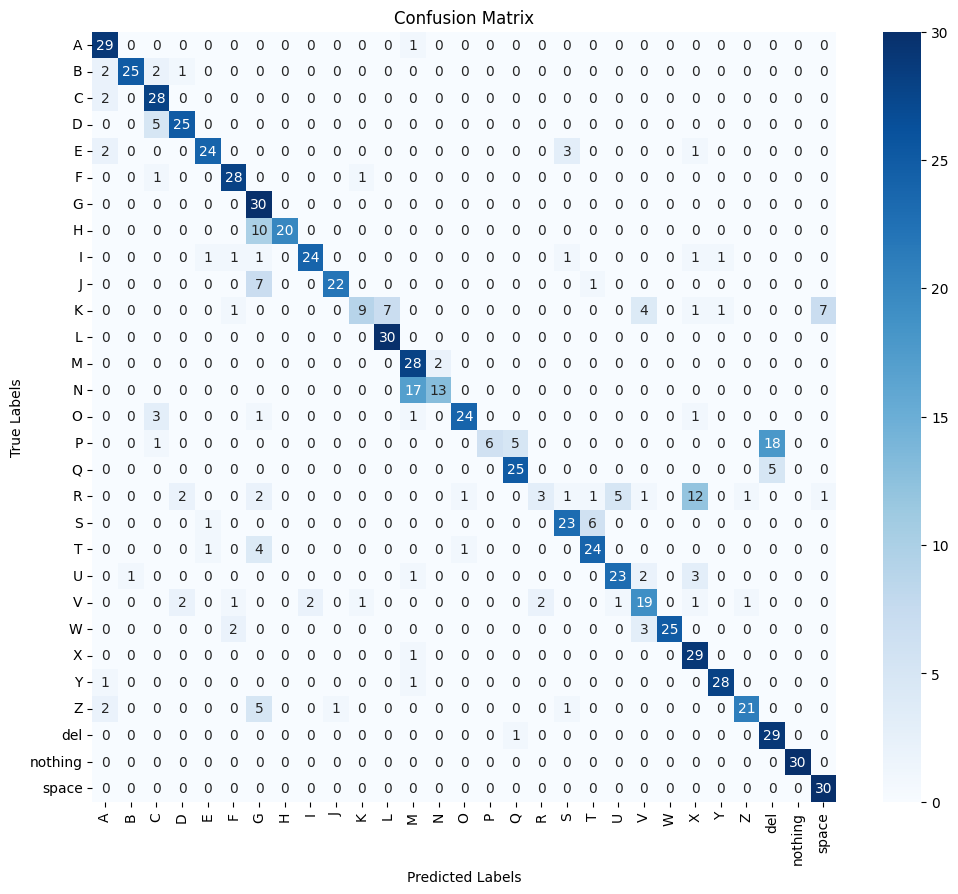

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

accuracy, f1, cm, report = results

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()